Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sales_of_company = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")



In [4]:
all_series = {
    "Sales": sales_of_company["Count"],
    "Robberies": robberies_in_boston["Count"],
    "Temperature": mean_monthly_temp["Deg"],
    "Dow_Jones": dowjones_closing["Close"],
    "Births": female_births["Count"]
}

In [5]:

from warnings import filterwarnings 
filterwarnings('ignore')

Применим GARCH к ряду Sales

In [6]:

%%time

best_aic_sales = np.inf 
best_order_sales = None
best_mdl_sales = None

for i in range(10):
    for d in range(10):
        for j in range(10):
            try:
                tmp_mdl = smt.ARIMA(all_series['Sales'], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic_sales:
                    best_aic_sales = tmp_aic
                    best_order_sales = (i, d, j)
                    best_mdl_sales = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_sales, best_order_sales))

aic: 858.17298 | order: (3, 1, 2)
Wall time: 52.9 s


In [11]:
from arch import arch_model

In [12]:

p_sales, o_sales, q_sales = best_order_sales

am_sales_garch = arch_model(all_series['Sales'], p=p_sales, o=o_sales, q=q_sales, dist='StudentsT')
res_sales_garch = am_sales_garch.fit(update_freq=5, disp='off')

am_sales_arch = arch_model(all_series['Sales'], p=p_sales, o=o_sales, q=q_sales, dist='StudentsT', vol='ARCH')
res_sales_arch = am_sales_arch.fit(update_freq=5, disp='off')
print('GARCH model')
print(res_sales_garch.summary())
print('+++++++++++++++++++++++++')
print('ARCH model')
print(res_sales_arch.summary())

GARCH model
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                      -0.126
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.126
Vol Model:                        GJR-GARCH   Log-Likelihood:               -498.293
Distribution:      Standardized Student's t   AIC:                           1014.59
Method:                  Maximum Likelihood   BIC:                           1035.68
                                              No. Observations:                   77
Date:                      Mon, Feb 01 2021   Df Residuals:                       68
Time:                              23:30:36   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------

Тоже самое к Birth

In [9]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


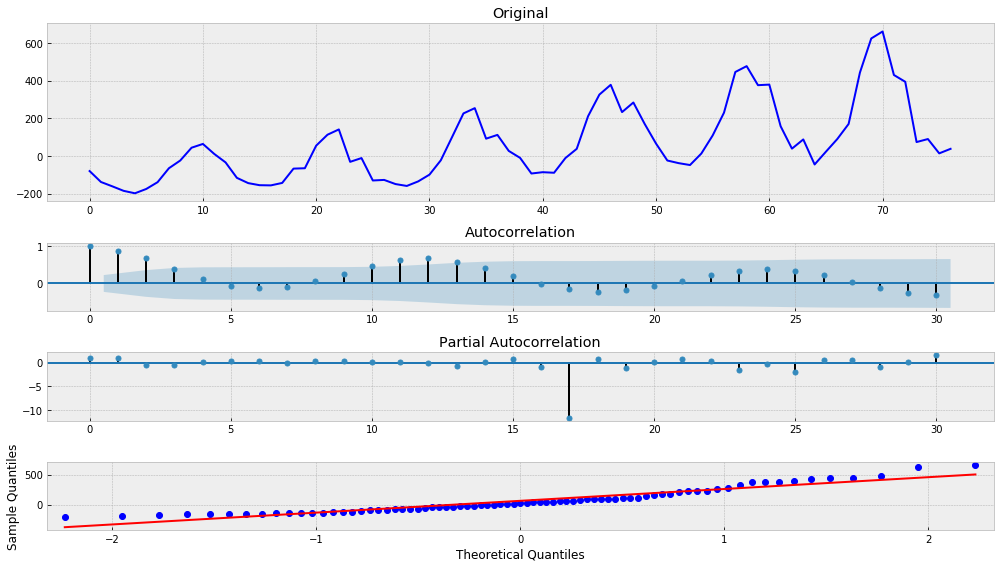

In [14]:
tsplot(res_sales_arch.resid, lags=30)

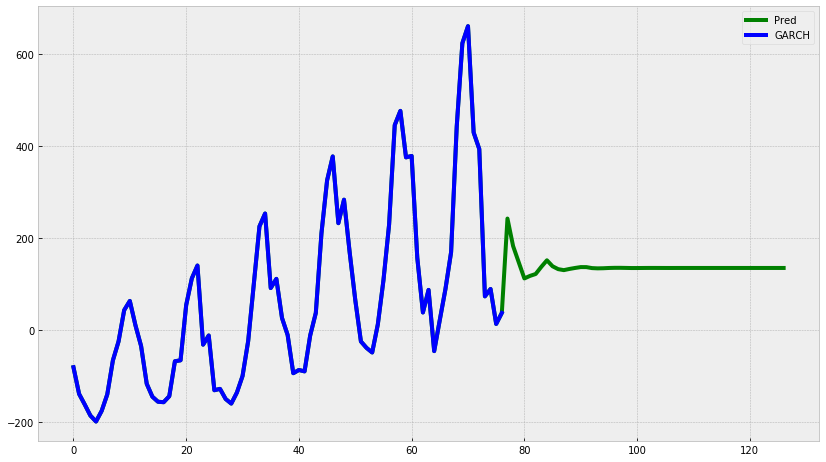

In [16]:
series_pred = predict(pd.Series(res_sales_arch.resid), 7, 50)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(pd.Series(res_sales_arch.resid), color='blue', linewidth='4', label='GARCH')
    plt.legend()